In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, RobustScaler, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import xgboost as xgb

In [3]:
def evaluate_model(model, X_train, y_train, X_test, y_test, class_names=['Ia','Ibc','II']):
  print("The training set:")
  y_train_pred = model.predict(X_train)
  print("\n Validation accuracy: ", accuracy_score(y_train, y_train_pred))
  print("\n Classification report:\n ",classification_report(y_train, y_train_pred))
  print("\n Confusion matrix:\n", confusion_matrix(y_train, y_train_pred))

  print("\nThe test set:")
  y_test_pred = model.predict(X_test)
  print("\n Validation accuracy: ", accuracy_score(y_test, y_test_pred))
  print("\n Classification report:\n ",classification_report(y_test, y_test_pred))
  print("\n Confusion matrix: \n", confusion_matrix(y_test, y_test_pred))

  # ---- ROC Curve ----
  classes = model.classes_
  n_classes = len(classes)
  y_test_bin = label_binarize(y_test, classes=classes)
  y_score = model.predict_proba(X_test)

  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

  plt.figure(figsize=(7,6))
  colors = plt.cm.get_cmap('Set1', n_classes)
  for i in range(n_classes):
    label = f"Class {i}" if class_names is None else class_names[i]
    plt.plot(fpr[i], tpr[i], color=colors(i), lw=2, label=f'{label} (AUC = {roc_auc[i]:.2f})')

  plt.plot([0,1], [0,1], 'k--', lw=1)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Multi-class ROC Curve')
  plt.legend(loc='lower right')
  plt.grid(True)
  plt.show()

In [4]:
# load data
Ia = pd.read_csv('/content/drive/My Drive/Colab Notebooks/ML_Fall2025_Supernovae/ML_master_table_TypeIa.csv')
Ibc = pd.read_csv('/content/drive/My Drive/Colab Notebooks/ML_Fall2025_Supernovae/ML_master_table_TypeIbc.csv')
II = pd.read_csv('/content/drive/My Drive/Colab Notebooks/ML_Fall2025_Supernovae/ML_master_table_TypeII.csv')

Attempt 1: Original data

In [6]:
data = pd.concat([Ia, Ibc, II], ignore_index=True)
data = data.dropna()
data = data.sample(frac=1, random_state=42).reset_index(drop=True)

skip = {'sn_name', 'sn_type', 'band'}
feature_cols = [c for c in data.columns if c not in skip]

# features
X = data[feature_cols]

Q1 = X.quantile(0.25)
Q3 = X.quantile(0.75)
IQR = Q3 - Q1

lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

X = X.clip(lower=lower, upper=upper, axis=1)

# labels
y = data['sn_type']
print("Unique mapped labels:", y.unique())

name_Ia = ['Ia','IaQ','Ia_Pec']
name_II = ['II','II_P','IIP','IIQ','II_L','II_Pec']

y = y.apply(lambda v: 0 if v in name_Ia else (2 if v in name_II else 1))

# count examples in classes
pd.Series(y).value_counts()

Unique mapped labels: ['II' 'Ia' 'Ib_c' 'Ib' 'Ia_Pec' 'IaQ' 'Ic' 'Ic_Pec' 'II_P' 'IIQ' 'IIP'
 'Ib-pec' 'II_L' 'IcQ' 'II_Pec' 'Ic/Ic-BL']


,count
sn_type,
0,12590
2,12447
1,600


In [7]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y,
    shuffle=True
)

scaler = RobustScaler()
X_train1 = scaler.fit_transform(X_train1)
X_test1 = scaler.transform(X_test1)

In [8]:
model1 = xgb.XGBClassifier(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=6,
    min_child_weight=3,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='multi:softprob',
    num_class=3,
    eval_metric='mlogloss',
    early_stopping_rounds=50
)

model1.fit(
    X_train1, y_train1,
    eval_set=[(X_test1, y_test1)]
)

[0]	validation_0-mlogloss:0.95620
[1]	validation_0-mlogloss:0.93658
[2]	validation_0-mlogloss:0.91559
[3]	validation_0-mlogloss:0.89562
[4]	validation_0-mlogloss:0.87780
[5]	validation_0-mlogloss:0.86105
[6]	validation_0-mlogloss:0.84482
[7]	validation_0-mlogloss:0.83173
[8]	validation_0-mlogloss:0.81774
[9]	validation_0-mlogloss:0.80494
[10]	validation_0-mlogloss:0.79261
[11]	validation_0-mlogloss:0.78103
[12]	validation_0-mlogloss:0.77030
[13]	validation_0-mlogloss:0.75996
[14]	validation_0-mlogloss:0.75142
[15]	validation_0-mlogloss:0.74330
[16]	validation_0-mlogloss:0.73566
[17]	validation_0-mlogloss:0.72769
[18]	validation_0-mlogloss:0.71979
[19]	validation_0-mlogloss:0.71338
[20]	validation_0-mlogloss:0.70687
[21]	validation_0-mlogloss:0.70124
[22]	validation_0-mlogloss:0.69555
[23]	validation_0-mlogloss:0.68958
[24]	validation_0-mlogloss:0.68467
[25]	validation_0-mlogloss:0.67950
[26]	validation_0-mlogloss:0.67498
[27]	validation_0-mlogloss:0.67136
[28]	validation_0-mlogloss:0.6

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=50,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=400, n_jobs=None, num_class=3, ...)

The training set:

 Validation accuracy:  0.7853137646886733

 Classification report:
                precision    recall  f1-score   support

           0       0.77      0.81      0.79     10072
           1       0.96      0.18      0.30       480
           2       0.80      0.79      0.79      9957

    accuracy                           0.79     20509
   macro avg       0.84      0.59      0.63     20509
weighted avg       0.79      0.79      0.78     20509


 Confusion matrix:
 [[8158    4 1910]
 [ 280   85  115]
 [2094    0 7863]]

The test set:

 Validation accuracy:  0.75

 Classification report:
                precision    recall  f1-score   support

           0       0.74      0.77      0.76      2518
           1       1.00      0.09      0.17       120
           2       0.76      0.76      0.76      2490

    accuracy                           0.75      5128
   macro avg       0.83      0.54      0.56      5128
weighted avg       0.76      0.75      0.74      5128


 C

/tmp/ipython-input-3970579071.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('Set1', n_classes)


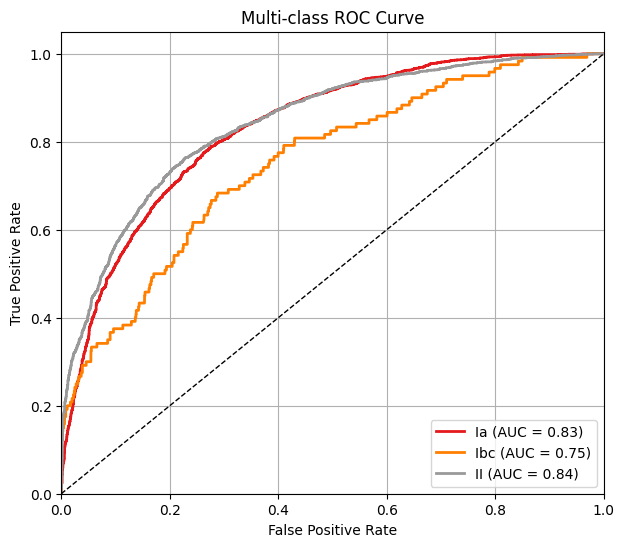

In [9]:
evaluate_model(model1, X_train1, y_train1, X_test1, y_test1)

Attempt 2: Downsampling

In [10]:
Ia_down = Ia.sample(1000)
II_down = II.sample(1000)

data_down = pd.concat([Ia_down, Ibc, II_down], ignore_index=True)
data_down = data_down.dropna()
data_down = data_down.sample(frac=1, random_state=42).reset_index(drop=True)

# features
X_down = data_down[feature_cols]

Q1 = X_down.quantile(0.25)
Q3 = X_down.quantile(0.75)
IQR = Q3 - Q1

lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

X_down = X_down.clip(lower=lower, upper=upper, axis=1)

# labels
y_down = data_down['sn_type']
print("Unique mapped labels:", y_down.unique())

y_down = y_down.apply(lambda v: 0 if v in name_Ia else (2 if v in name_II else 1))

# count examples in classes
pd.Series(y_down).value_counts()

Unique mapped labels: ['Ic' 'Ib' 'II' 'Ia' 'Ib_c' 'II_P' 'IaQ' 'IIQ' 'IcQ' 'Ic_Pec' 'IIP'
 'Ia_Pec' 'Ib-pec' 'Ic/Ic-BL']


,count
sn_type,
0,1000
2,989
1,600


In [11]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(
    X_down, y_down,
    test_size=0.2,
    random_state=42,
    stratify=y_down,
    shuffle=True
)

scaler = RobustScaler()
X_train2 = scaler.fit_transform(X_train2)
X_test2 = scaler.transform(X_test2)

In [26]:
model2 = xgb.XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='multi:softprob',
    num_class=3,
    eval_metric='mlogloss',
    early_stopping_rounds=50
)

model2.fit(
    X_train2, y_train2,
    eval_set=[(X_test2, y_test2)]
)

[0]	validation_0-mlogloss:1.07593
[1]	validation_0-mlogloss:1.06481
[2]	validation_0-mlogloss:1.05377
[3]	validation_0-mlogloss:1.04408
[4]	validation_0-mlogloss:1.03537
[5]	validation_0-mlogloss:1.02661
[6]	validation_0-mlogloss:1.01708
[7]	validation_0-mlogloss:1.01016
[8]	validation_0-mlogloss:1.00332
[9]	validation_0-mlogloss:0.99757
[10]	validation_0-mlogloss:0.99205
[11]	validation_0-mlogloss:0.98600
[12]	validation_0-mlogloss:0.98137
[13]	validation_0-mlogloss:0.97667
[14]	validation_0-mlogloss:0.97269
[15]	validation_0-mlogloss:0.96941
[16]	validation_0-mlogloss:0.96611
[17]	validation_0-mlogloss:0.96272
[18]	validation_0-mlogloss:0.95906
[19]	validation_0-mlogloss:0.95600
[20]	validation_0-mlogloss:0.95295
[21]	validation_0-mlogloss:0.95109
[22]	validation_0-mlogloss:0.94890
[23]	validation_0-mlogloss:0.94720
[24]	validation_0-mlogloss:0.94558
[25]	validation_0-mlogloss:0.94387
[26]	validation_0-mlogloss:0.94262
[27]	validation_0-mlogloss:0.94169
[28]	validation_0-mlogloss:0.9

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=50,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None, num_class=3, ...)

The training set:

 Validation accuracy:  0.7532592950265572

 Classification report:
                precision    recall  f1-score   support

           0       0.69      0.84      0.76       800
           1       0.87      0.49      0.63       480
           2       0.78      0.82      0.80       791

    accuracy                           0.75      2071
   macro avg       0.78      0.72      0.73      2071
weighted avg       0.77      0.75      0.75      2071


 Confusion matrix:
 [[672  21 107]
 [168 237  75]
 [127  13 651]]

The test set:

 Validation accuracy:  0.5694980694980695

 Classification report:
                precision    recall  f1-score   support

           0       0.52      0.67      0.59       200
           1       0.67      0.27      0.38       120
           2       0.60      0.65      0.63       198

    accuracy                           0.57       518
   macro avg       0.60      0.53      0.53       518
weighted avg       0.59      0.57      0.55       518

/tmp/ipython-input-3970579071.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('Set1', n_classes)


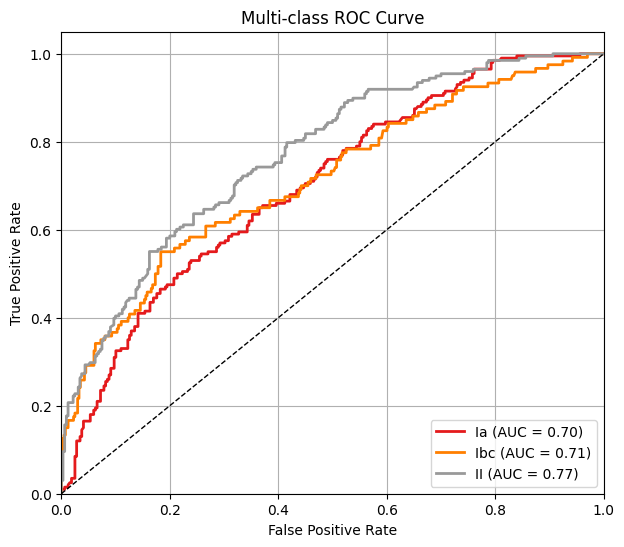

In [27]:
evaluate_model(model2, X_train2, y_train2, X_test2, y_test2)